In [1]:
'''
Домашнее задание к семинару 07 (HW07)
Тема: кластеризация, внутренние метрики качества, PCA/t-SNE и "честный" unsupervised-эксперимент на синтетических данных.
'''
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from json import dump

In [2]:
'''
2.3.1. Загрузка данных и первичный анализ (для каждого датасета)
1) Загрузить CSV в `pandas.DataFrame`.
'''
df1 = pd.read_csv("./data/S07-hw-dataset-01.csv")
df2 = pd.read_csv("./data/S07-hw-dataset-02.csv")
df3 = pd.read_csv("./data/S07-hw-dataset-03.csv")


In [3]:
'''
2) Зафиксировать минимум:
   - `head()`, `info()`, базовые статистики (`describe()` или аналог);
   - проверка пропусков (кол-во/доли);
   - типы признаков (числовые / категориальные).  
'''
df1.head()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [4]:
df2.head()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [5]:
df3.head()

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [8]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


In [9]:
df1.describe()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


In [10]:
df2.describe()

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [11]:
df3.describe()

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


In [12]:
print(df1.isna().sum(), df2.isna().sum(), df3.isna().sum(), sep='\n\n')

sample_id    0
f01          0
f02          0
f03          0
f04          0
f05          0
f06          0
f07          0
f08          0
dtype: int64

sample_id    0
x1           0
x2           0
z_noise      0
dtype: int64

sample_id    0
x1           0
x2           0
f_corr       0
f_noise      0
dtype: int64


In [13]:
print(df1.dtypes, df2.dtypes, df3.dtypes, sep='\n\n')

sample_id      int64
f01          float64
f02          float64
f03          float64
f04          float64
f05          float64
f06          float64
f07          float64
f08          float64
dtype: object

sample_id      int64
x1           float64
x2           float64
z_noise      float64
dtype: object

sample_id      int64
x1           float64
x2           float64
f_corr       float64
f_noise      float64
dtype: object


In [14]:
'''
3) Определить:
   - `X` – признаки (все столбцы, кроме `sample_id`);
   - `sample_id` хранить отдельно (для сохранения результатов).
'''
X1 = df1.loc[:, df1.columns.difference(["sample_id"])]
X2 = df2.loc[:, df2.columns.difference(["sample_id"])]
X3 = df3.loc[:, df3.columns.difference(["sample_id"])]
sample_ids1 = df1["sample_id"]
sample_ids2 = df2["sample_id"]
sample_ids3 = df3["sample_id"]

In [15]:
# 2.3.2. Препроцессинг (обязательно)
def preprocess(X):
    preprocessor = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    )
    preprocessedX = preprocessor.fit_transform(X)
    return preprocessedX


X1_preprocessed = preprocess(X1)
X2_preprocessed = preprocess(X2)
X3_preprocessed = preprocess(X3)

In [ ]:
# 2.3.3. Модели недели 7 (для каждого датасета – минимум 2 алгоритма) + все последующие пункты
def kmeans(X, dfName, rs=42, saveFigs=True):
    k_range = range(2, 21)

    silhouette_scores = []
    best_silhouette = -2
    best_k = 0

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=rs, n_init=10)
        labels = kmeans.fit_predict(X)
        current = silhouette_score(X, labels)
        silhouette_scores.append(current)
        if (current > best_silhouette):
            best_silhouette = current
            best_model = kmeans
            best_k = k
    
    plt.plot(k_range, silhouette_scores)
    plt.title(f"{dfName}. SilhouetteVSk. random_state={rs}")
    plt.xlabel("k")
    plt.ylabel("silhouette_score")
    if (saveFigs):
        plt.savefig(f"/artifacts/figures/silhouetteVSk_{dfName}.png")
    plt.show()

    best_labels = best_model.fit_predict(X)
    best_davies_bouldin_score = davies_bouldin_score(X, best_labels)
    best_calinski_harabasz_score = calinski_harabasz_score(X, best_labels)

    result = {"dfName": dfName,
              "algorithm": "KMeans",
              "model": best_model,
              "labels": best_labels,
              "params": {"k": best_k},
              "metrics": {"silhouette_score": best_silhouette, "davies_bouldin_score": best_davies_bouldin_score, "calinski_harabasz_score": best_calinski_harabasz_score}
    }

    return result

In [17]:
def agglomerative_clustering(X, dfName):
    k_range = range(2, 21)
    linkages = ["ward", "complete"]

    best_silhouette = -2
    best_k = 0
    best_linkage = "ward"

    for k in k_range:
        for la in linkages:
            agglo = AgglomerativeClustering(n_clusters=k, linkage=la)
            labels = agglo.fit_predict(X)
            current = silhouette_score(X, labels)
            if (current > best_silhouette):
                best_silhouette = current
                best_model = agglo
                best_k = k
                best_linkage = la

    best_labels = best_model.fit_predict(X)
    best_davies_bouldin_score = davies_bouldin_score(X, best_labels)
    best_calinski_harabasz_score = calinski_harabasz_score(X, best_labels)

    result = {"dfName": dfName,
              "algorithm": "AgglomerativeClustering",
              "model": best_model,
              "labels": best_labels,
              "params": {"k": best_k, "linkage": best_linkage},
              "metrics": {"silhouette_score": best_silhouette, "davies_bouldin_score": best_davies_bouldin_score, "calinski_harabasz_score": best_calinski_harabasz_score}
    }

    return result

In [18]:
def dbscan_clustering(X, dfName):
    
    param_combinations = [
        {'eps': 0.3, 'min_samples': 5},
        {'eps': 0.5, 'min_samples': 5},
        {'eps': 0.5, 'min_samples': 10},
        {'eps': 0.7, 'min_samples': 5},
        {'eps': 0.7, 'min_samples': 10},
        {'eps': 1.0, 'min_samples': 5},
        {'eps': 1.0, 'min_samples': 10},
        {'eps': 1.5, 'min_samples': 5},
        {'eps': 2.0, 'min_samples': 5},
    ]
    
    best_score = -2
    best_result = None
    
    for params in param_combinations:
        dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
        labels = dbscan.fit_predict(X)
        
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels)
        if -1 in unique_labels:
            n_clusters -= 1

        if n_clusters >= 1:
            noise_ratio = np.sum(labels == -1) / len(labels)

            if noise_ratio < 0.95:
                mask = labels != -1
                if mask.sum() > 0:
                    unique_non_noise = np.unique(labels[mask])
                    if len(unique_non_noise) >= 2:
                        try:
                            score = silhouette_score(X[mask], labels[mask])
                            if score > best_score:
                                best_score = score
                                best_result = {
                                    'model': dbscan,
                                    'labels': labels,
                                    'params': params,
                                    'score': score,
                                    'n_clusters': n_clusters,
                                    'noise_ratio': noise_ratio
                                }
                        except:
                            pass

    if best_result is None:
        params = param_combinations[0]
        dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
        labels = dbscan.fit_predict(X)
        best_result = {
            'model': dbscan,
            'labels': labels,
            'params': params,
            'score': -1,
            'n_clusters': len(np.unique(labels)) - (1 if -1 in labels else 0),
            'noise_ratio': np.sum(labels == -1) / len(labels)
        }
    
    labels = best_result['labels']
    eps = best_result['params']['eps']
    min_samples = best_result['params']['min_samples']
    
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    if -1 in unique_labels:
        n_clusters -= 1
    
    noise_count = np.sum(labels == -1)
    noise_ratio = noise_count / len(labels)
    
    mask = labels != -1
    if mask.sum() > 0 and len(np.unique(labels[mask])) >= 2:
        silhouette = silhouette_score(X[mask], labels[mask])
        davies_bouldin = davies_bouldin_score(X[mask], labels[mask])
    else:
        silhouette = -1
        davies_bouldin = float('inf')
    
    if n_clusters >= 2:
        calinski_harabasz = calinski_harabasz_score(X[mask], labels[mask])
    else:
        calinski_harabasz = 0
    
    return {
        "dfName": dfName,
        "algorithm": "DBSCAN",
        "model": best_result['model'],
        "labels": labels,
        "params": {"eps": eps, "min_samples": min_samples},
        "metrics": {
            "silhouette_score": silhouette,
            "davies_bouldin_score": davies_bouldin,
            "calinski_harabasz_score": calinski_harabasz,
            "noise_ratio": noise_ratio
        }
    }

In [ ]:
def visualize_clusters_pca(X, labels, dfName, algorithm_name):
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    plt.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=labels, cmap='Set2', s=50, alpha=0.8,
        edgecolors='k', linewidth=0.5
    )
    plt.xlabel(f'PC1')
    plt.ylabel(f'PC2')
    plt.title(f'PCA Visualization. {algorithm_name}')
    plt.savefig(f"./artifacts/figures/best_model_PCA_{dfName}.png")
    plt.show()

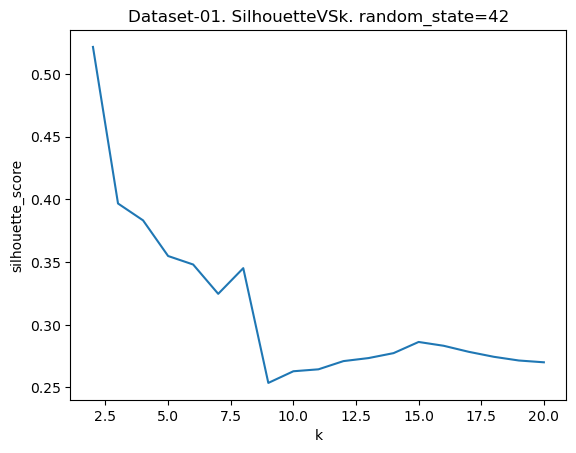

Опробованные модели (сверху - самые эффективные в рамках данного датасета):

Результаты применения алгоритма KMeans к датасету Dataset-01
Метрики качества:
silhouette_score: 0.5216395622404242
davies_bouldin_score: 0.6853295219054456
calinski_harabasz_score: 11786.954622671532
Подобранные лучшие гиперпараметры:
k: 2
Результаты применения алгоритма AgglomerativeClustering к датасету Dataset-01
Метрики качества:
silhouette_score: 0.5216395622404242
davies_bouldin_score: 0.6853295219054456
calinski_harabasz_score: 11786.954622671532
Подобранные лучшие гиперпараметры:
k: 2
linkage: ward
Результаты применения алгоритма DBSCAN к датасету Dataset-01
Метрики качества:
silhouette_score: 0.5216395622404242
davies_bouldin_score: 0.6853295219054456
calinski_harabasz_score: 11786.954622671532
noise_ratio: 0.0
Подобранные лучшие гиперпараметры:
eps: 2.0
min_samples: 5


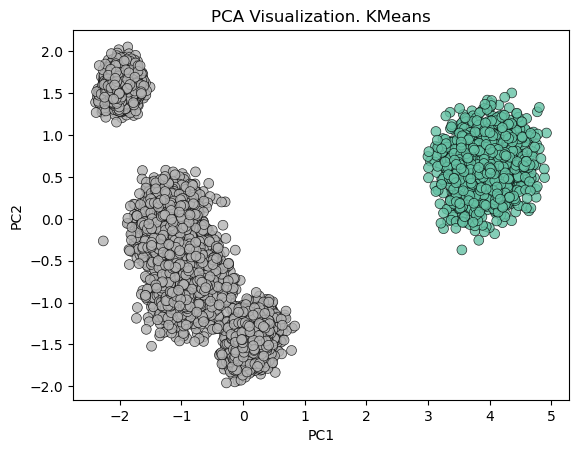

In [20]:
# Dataset-01
DF1 = [kmeans(X1_preprocessed, "Dataset-01"), agglomerative_clustering(X1_preprocessed, "Dataset-01"), dbscan_clustering(X1_preprocessed, "Dataset-01")]
best_model1 = sorted(DF1, key=lambda x: x['metrics']['silhouette_score'], reverse=True)[0]
print("Опробованные модели (сверху - самые эффективные в рамках данного датасета):", end='\n\n')
for model in DF1:
    print(f"Результаты применения алгоритма {model['algorithm']} к датасету {model['dfName']}")
    print("Метрики качества:")
    for metric in model['metrics'].keys():
        print(f"{metric}: {model['metrics'][metric]}")
    print("Подобранные лучшие гиперпараметры:")
    for param in model['params']:
        print(f"{param}: {model['params'][param]}")
    print('=' * 30)
visualize_clusters_pca(X1_preprocessed, best_model1['labels'], best_model1['dfName'], best_model1['algorithm'])

Первый датасет оказался самым чистым из всех. Здесь практически не было шумов и кластеры имели формы более менее приближённые к сферической. Благодаря этому все модели справились с ним достаточно хорошо. Удалось разделить две большие группы объектов на два соответствующих кластера, а значит, модель отработала приемлемо. Лучшая модель: DBScan с параметрами eps: 2.0, min_samples: 5

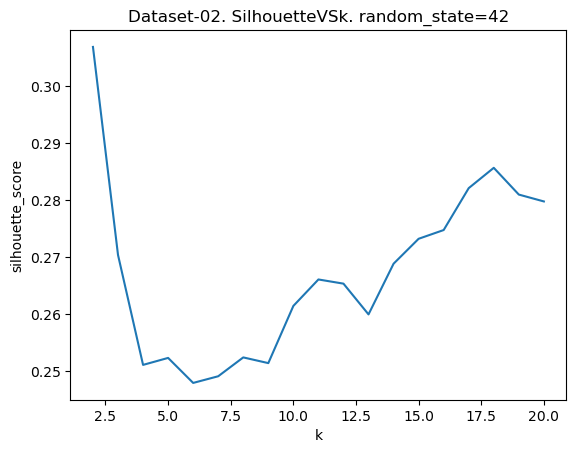

Опробованные модели (сверху - самые эффективные в рамках данного датасета):

Результаты применения алгоритма KMeans к датасету Dataset-02
Метрики качества:
silhouette_score: 0.3068577265637877
davies_bouldin_score: 1.32347174904028
calinski_harabasz_score: 3573.397676572467
Подобранные лучшие гиперпараметры:
k: 2
Результаты применения алгоритма AgglomerativeClustering к датасету Dataset-02
Метрики качества:
silhouette_score: 0.2658744116185544
davies_bouldin_score: 1.4673684423118982
calinski_harabasz_score: 2929.7223479920044
Подобранные лучшие гиперпараметры:
k: 2
linkage: ward
Результаты применения алгоритма DBSCAN к датасету Dataset-02
Метрики качества:
silhouette_score: 0.3049523469313708
davies_bouldin_score: 0.6006770767549849
calinski_harabasz_score: 114.42869204908136
noise_ratio: 0.036375
Подобранные лучшие гиперпараметры:
eps: 0.7
min_samples: 10


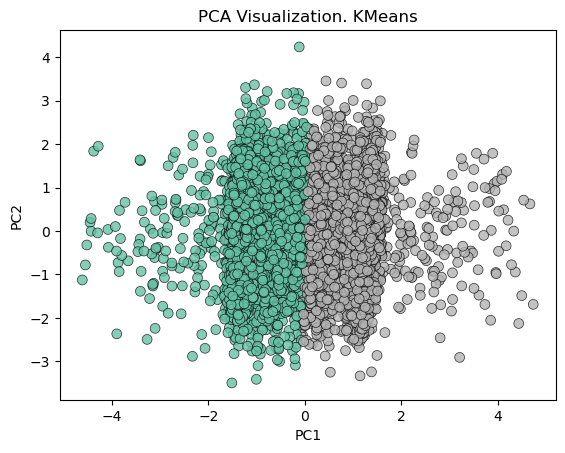

In [21]:
# Dataset-02
DF2 = [kmeans(X2_preprocessed, "Dataset-02"), agglomerative_clustering(X2_preprocessed, "Dataset-02"), dbscan_clustering(X2_preprocessed, "Dataset-02")]
best_model2 = sorted(DF2, key=lambda x: x['metrics']['silhouette_score'], reverse=True)[0]
print("Опробованные модели (сверху - самые эффективные в рамках данного датасета):", end='\n\n')
for model in DF2:
    print(f"Результаты применения алгоритма {model['algorithm']} к датасету {model['dfName']}")
    print("Метрики качества:")
    for metric in model['metrics'].keys():
        print(f"{metric}: {model['metrics'][metric]}")
    print("Подобранные лучшие гиперпараметры:")
    for param in model['params']:
        print(f"{param}: {model['params'][param]}")
    print('=' * 30)
visualize_clusters_pca(X2_preprocessed, best_model2['labels'], best_model2['dfName'], best_model2['algorithm'])

In [22]:
print(f"Лучшая модель для датасета 2 - {best_model2['algorithm']}")
print(f"Её параметры:\n{best_model2['params']}")

Лучшая модель для датасета 2 - KMeans
Её параметры:
{'k': 2}


Имел большое скопление точек посередине и множество выбросов вокруг, что не позволяло явно разделить его на два кластера, из-за чего многие алгоритмы путались. Здесь лучше всего справился самый обычный kmeans, так как он просто разделил объекты пополам на два практически равных кластера, не пытаясь "сильно думать". Это немного нестандартный датасет для задачи кластеризации, так как кластеризация подразумевает собой разделение данных на **несколько** кластеров. Тут же, если судить по графику, как будто лучшим варинатом было бы просто сделать одну единую группу посередине, а всё остальное считать шумом. Поэтому будем считать решение KMeans приемлемым: он **разделил** данные на кластеры, как ему и полагалось сделать. Лучшая модель: KMeans с параметром k=2

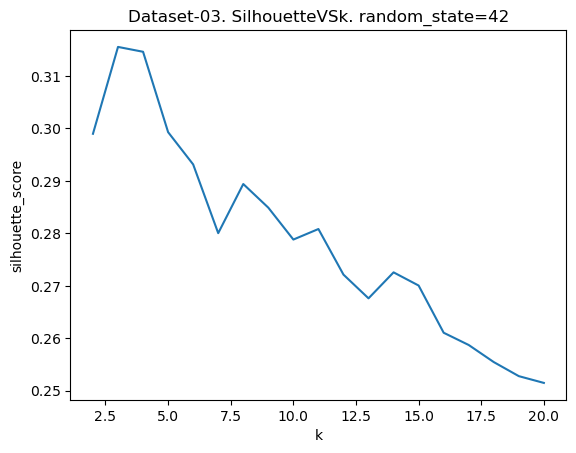

Опробованные модели (сверху - самые эффективные в рамках данного датасета):

Результаты применения алгоритма KMeans к датасету Dataset-03
Метрики качества:
silhouette_score: 0.31554470037825183
davies_bouldin_score: 1.1577256320598663
calinski_harabasz_score: 6957.162639510167
Подобранные лучшие гиперпараметры:
k: 3
Результаты применения алгоритма AgglomerativeClustering к датасету Dataset-03
Метрики качества:
silhouette_score: 0.3094002930793223
davies_bouldin_score: 1.1775936042245867
calinski_harabasz_score: 6705.577295073578
Подобранные лучшие гиперпараметры:
k: 3
linkage: ward
Результаты применения алгоритма DBSCAN к датасету Dataset-03
Метрики качества:
silhouette_score: 0.14243088104506604
davies_bouldin_score: 1.3932351326290713
calinski_harabasz_score: 1640.790703583512
noise_ratio: 0.0324
Подобранные лучшие гиперпараметры:
eps: 0.5
min_samples: 10


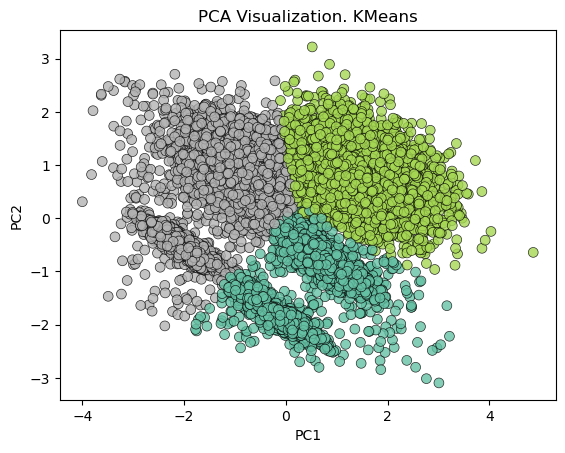

In [23]:
# Dataset-03
DF3 = [kmeans(X3_preprocessed, "Dataset-03"), agglomerative_clustering(X3_preprocessed, "Dataset-03"), dbscan_clustering(X3_preprocessed, "Dataset-03")]
best_model3 = sorted(DF3, key=lambda x: x['metrics']['silhouette_score'], reverse=True)[0]
print("Опробованные модели (сверху - самые эффективные в рамках данного датасета):", end='\n\n')
for model in DF3:
    print(f"Результаты применения алгоритма {model['algorithm']} к датасету {model['dfName']}")
    print("Метрики качества:")
    for metric in model['metrics'].keys():
        print(f"{metric}: {model['metrics'][metric]}")
    print("Подобранные лучшие гиперпараметры:")
    for param in model['params']:
        print(f"{param}: {model['params'][param]}")
    print('=' * 30)
visualize_clusters_pca(X3_preprocessed, best_model3['labels'], best_model3['dfName'], best_model3['algorithm'])

In [24]:
print(f"Лучшая модель для датасета 3 - {best_model3['algorithm']}")
print(f"Её параметры:\n{best_model3['params']}")

Лучшая модель для датасета 3 - KMeans
Её параметры:
{'k': 3}


Был достаточно сложным для кластеризации, так как имел неочевидные формы кластеров, разную плотность и небольшое количество шума. Лучшей моделью оказался KMeans с параметром k=3

Проверка стабильности модели kmeans на датафрейме 01


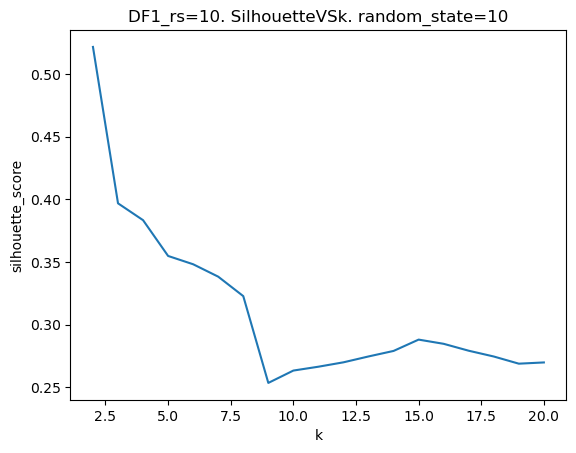

silhouette_score: 0.5216395622404242
davies_bouldin_score: 0.6853295219054456
calinski_harabasz_score: 11786.954622671532


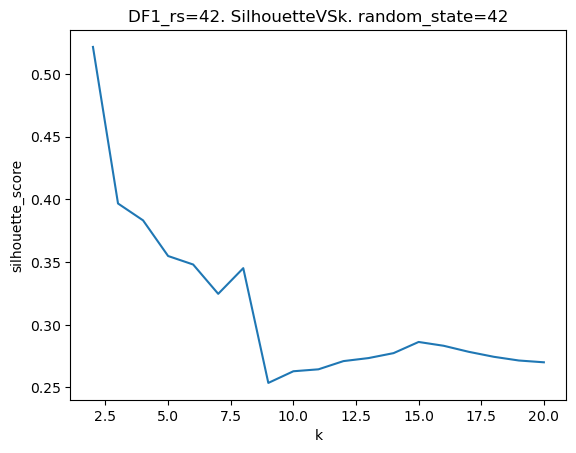

silhouette_score: 0.5216395622404242
davies_bouldin_score: 0.6853295219054456
calinski_harabasz_score: 11786.954622671532


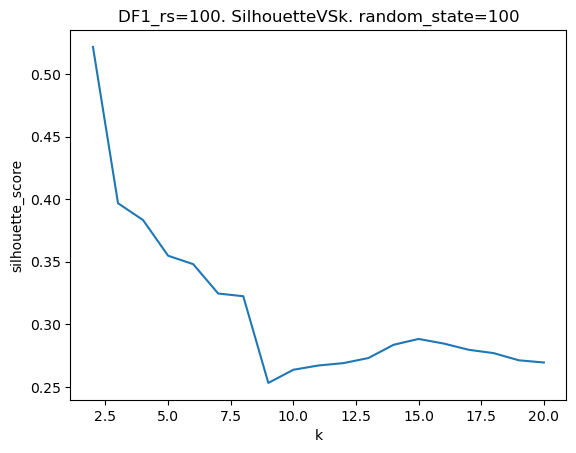

silhouette_score: 0.5216395622404242
davies_bouldin_score: 0.6853295219054456
calinski_harabasz_score: 11786.954622671532


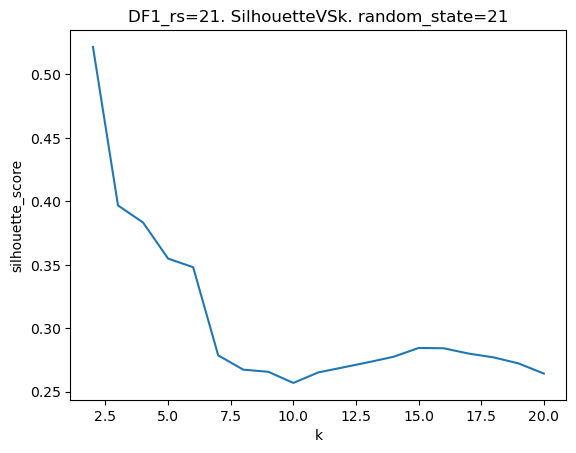

silhouette_score: 0.5216395622404242
davies_bouldin_score: 0.6853295219054456
calinski_harabasz_score: 11786.954622671532


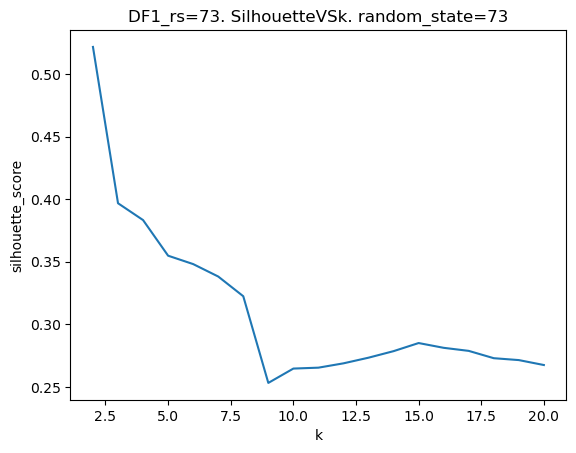

silhouette_score: 0.5216395622404242
davies_bouldin_score: 0.6853295219054456
calinski_harabasz_score: 11786.954622671532


In [25]:
#Проверка устойчивости
rsArray = [10, 42, 100, 21, 73]
print("Проверка стабильности модели kmeans на датафрейме 01")
for rs in rsArray:
    model = kmeans(X1_preprocessed, f"DF1_rs={rs}", rs, saveFigs=False)
    for metric in model['metrics'].keys():
        print(f"{metric}: {model['metrics'][metric]}")

In [ ]:
# 2.4. Артефакты эксперимента (обязательно)
summary = {
    "DF1": {
        "KMeans": DF1[0]['metrics'],
        "AgglomerativeClustering": DF1[1]['metrics'],
        "DBSCAN": DF1[2]['metrics']
    },
    "DF2": {
        "KMeans": DF2[0]['metrics'],
        "AgglomerativeClustering": DF2[1]['metrics'],
        "DBSCAN": DF2[2]['metrics']
    },
    "DF3": {
        "KMeans": DF3[0]['metrics'],
        "AgglomerativeClustering": DF3[1]['metrics'],
        "DBSCAN": DF3[2]['metrics']
    }
}
with open('./artifacts/metrics_summary.json', 'w', encoding='utf-8') as f:
    dump(summary, f)

In [ ]:
best_configs = {
    "DF1":{
        "best_method": best_model1['algorithm'],
        "best_params": best_model1['params'],
        "criteria": "silhouette_score"
    },
    "DF2":{
        "best_method": best_model2['algorithm'],
        "best_params": best_model2['params'],
        "criteria": "silhouette_score"
    },
    "DF3":{
        "best_method": best_model3['algorithm'],
        "best_params": best_model3['params'],
        "criteria": "silhouette_score"
    }
}
with open('./artifacts/best_configs.json', 'w', encoding='utf-8') as f:
    dump(best_configs, f)

In [ ]:
#`labels/` – CSV-файлы с присвоенными кластерами для **лучшего** решения на каждом датасете
clusters1 = pd.DataFrame({
    'sample_id': sample_ids1,
    'labels': best_model1['labels']
})
clusters2 = pd.DataFrame({
    'sample_id': sample_ids2,
    'labels': best_model2['labels']
})
clusters3 = pd.DataFrame({
    'sample_id': sample_ids3,
    'labels': best_model3['labels']
})
clusters1.to_csv('./artifacts/labels_hw07_ds1.csv', sep=';', index=False)
clusters2.to_csv('./artifacts/labels_hw07_ds2.csv', sep=';', index=False)
clusters3.to_csv('./artifacts/labels_hw07_ds3.csv', sep=';', index=False)